# Joint Optimization of Masks and Deep Recurrent Neural Networks for Monaural Source Separation
## Implementation and Experiment

In [1]:
from itertools import islice

import os
import numpy as np
import tensorflow as tf
import python_speech_features as psp
import IPython
from IPython.display import Audio, display
from scipy.io import wavfile

%matplotlib inline
import matplotlib.pyplot as plt

from features.wav_iterator import batcher, wav_iterator
from features.wav_iterator import lmf_iterator, stft_iterator
from features.spectral_features import stft, istft

audio_dir = os.environ['AUDIO_PATH']

## Data

In [2]:
sig_length = 75
stft_step = 256
stft_len = 512
freq_extent = stft_len // 2 + 1
fs = 16000

wavs = wav_iterator(audio_dir, sig_length=sig_length*stft_step)
sb = stft_iterator(wavs, stft_len=stft_len, stft_step=stft_step, use_diffs=False, two_sided=False)

In [3]:
def plot_mix(src1, src2, mix, rot=False, cmap="afmhot_r"):
    """
    Plot original data
    """
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1,4,1)
    if rot:
        org = 'bottom'
        src1 = src1.T
        src2 = src2.T
        mix = mix.T
    else:
        org = 'top'
    
    ax.set_title("Truth A")
    im = ax.matshow(src1, cmap=cmap, interpolation='none', origin = org)
    plt.colorbar(im, shrink=0.25)
    ax = plt.subplot(1,4,2)
    ax.set_title("Truth B")
    im = ax.matshow(src2, cmap=cmap, interpolation='none', origin = org)
    plt.colorbar(im, shrink=0.25)
    ax = plt.subplot(1,4,3)
    ax.set_title("Mix")
    im =ax.matshow(mix, cmap=cmap, interpolation='none', origin = org)
    plt.colorbar(im, shrink=0.25)


def plot_recons(src_recon1, src_recon2, rot=False, cmap="afmhot_r"):
    """
    Plot reconstructions
    """
    if rot:
        org = 'bottom'
        src_recon1 = src_recon1.T
        src_recon2 = src_recon2.T
    else:
        org = 'top'    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1,3,1)
    ax.set_title("Recon A")
    im = ax.matshow(src_recon1, cmap=cmap, interpolation='none', origin = org)
    plt.colorbar(im, shrink=0.5)
    ax = plt.subplot(1,3,2)
    ax.set_title("Recon B")
    im = ax.matshow(src_recon2, cmap=cmap, interpolation='none', origin = org)
    plt.colorbar(im, shrink=0.5)
    
    

In [4]:
t, m = list(islice(sb,1))[0]

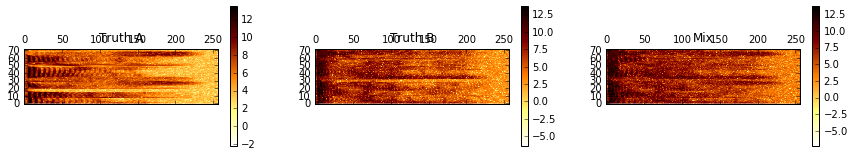

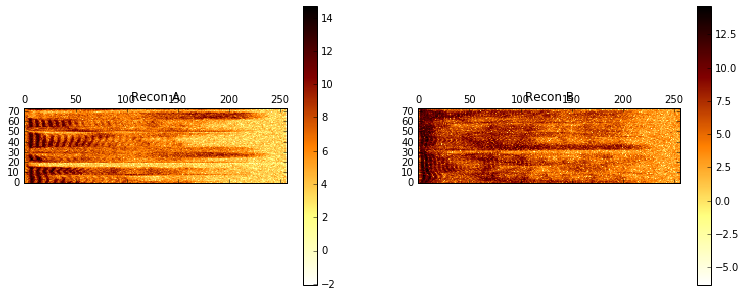

In [5]:
# Take log-magnitude spectrograms of truth signals and mix
s1 = np.log(np.absolute(t[0])).real
s2 = np.log(np.absolute(t[1].real))
mix = np.log(np.absolute(m.real))
plot_mix(s1, s2, mix, False)
# Add random noise to TF representation as mock "reconstruction"
s1_noise = s1+np.random.randn(*s1.shape)/2
s2_noise = s2+np.random.randn(*s2.shape)/2
plot_recons(s1_noise, s2_noise, False)
# Play "reconstruction" made by adding noise
# Will contain bloopy artifacts from noise insertion
s1_noise_audio = istft(np.absolute(np.exp(s1_noise)) * np.exp(1j * np.angle(m)), fs=1, 
                       recon_size=sig_length*stft_step, hop=stft_step, two_sided=False)
display(Audio(s1_noise_audio, rate=fs))

plt.show()

## Implementation of the network

The network diagram from Huang et al. is useful:
![Joint Optimization of Masks and Deep RNNs diagram](../../data/pictures/mask-rnn.png)

There are three feed-forward layers after the input. One (the second) has recurrent connections. After the third layer the network splits into two and computes two "pre-constructions" closelsy related to the final time-frequency reconstruction of both components. The final layer is the mask, computed deterministically from the preconstruction and constrained to be complementary across the two branches. This mask is applied to the "preconstructions" to generate the full time-frequency reconstructions.

Less clear is what is the masking opeartion doing, since the mask is the same for both reconstructions.
![Joint Optimization of Masks and Deep RNNs masking op](../../data/pictures/mask-rnn-mask.png)


### Tensorflow Implementation

In [6]:
batch_size = 256
num_steps = sig_length - 2
input_shape = freq_extent
ff1_size = 80
recurrent_size = 50
ff2_size = 80

tf.reset_default_graph()
sess = tf.Session()
with tf.variable_scope(tf.get_variable_scope()) as vscope:
    with tf.device("/gpu:0"):
        with sess.as_default():
            audio_features = tf.placeholder(tf.float32, shape=(None, num_steps, input_shape), name="audio_features")
            audio_truth = tf.placeholder(tf.float32, shape=(None, 2, num_steps, input_shape), name="audio_truth")
            ## Set up network
            # Feedforward 1
            feedforward_weights = tf.Variable(tf.random_normal((input_shape, ff1_size)), name="dense_wts_1")
            feedforward_bias = tf.Variable(tf.zeros((1, ff1_size)), name="dense_bias_1")
            # Recurrent layer
            recurrent_cell = tf.contrib.rnn.BasicLSTMCell(recurrent_size)
            #recurrent_cell = tf.contrib.rnn.BasicRNNCell(recurrent_size)
            recurrent_state = recurrent_cell.zero_state(batch_size, audio_features.dtype)
            # Feedforward 2
            feedforward_2_weights = tf.Variable(tf.random_normal((recurrent_size, ff2_size)), name="dense_wts_2")
            feedforward_2_bias = tf.Variable(tf.zeros((1, ff2_size)), name="dense_bias_2")
            # Preconstruction a (y_hat)
            precon_a_weights = tf.Variable(tf.random_normal((ff2_size, input_shape)), name="precon_a_wts")
            precon_a_bias = tf.Variable(tf.random_normal((1, input_shape)), name="precon_a_bias")
            # Preconstruction b
            precon_b_weights = tf.Variable(tf.random_normal((ff2_size, input_shape)), name="precon_b_wts")
            precon_b_bias = tf.Variable(tf.random_normal((1, input_shape)), name="precon_b_bias")
            # Mask
            mask_weights = tf.Variable(tf.ones((1,input_shape)), name="mask_wts")

            # Set up operations
            recons = {'a':[], 'b': []}
            # normalization
            af_mag = tf.abs(audio_features)
            af_mean, af_var = tf.nn.moments(af_mag, axes=[0, 1, 2])
            af_sqrt = tf.sqrt(af_mag)
            af_min, af_max = tf.reduce_min(af_sqrt), tf.reduce_max(af_sqrt)
            af_sqrt = tf.sqrt(audio_features)
            audio_features_norm = (af_sqrt - af_min) / (af_max - af_min)
            
            at_mag = tf.abs(audio_truth)
            at_mean, at_var = tf.nn.moments(at_mag, axes=[0, 1, 2])
            at_sqrt = tf.sqrt(at_mag)
            at_min, at_max = tf.reduce_min(at_sqrt), tf.reduce_max(at_sqrt)
            audio_truth_norm = (at_sqrt - at_min) / (at_max - at_min)
            
            for input_time in range(num_steps):
                if input_time > 0:
                    tf.get_variable_scope().reuse_variables()
                # Feedforward 1 ops
                if input_time==0:
                    print(audio_features_norm[:, input_time, :])
                    print(feedforward_weights.value())

                feedforward_out = tf.matmul(audio_features_norm[:, input_time, :],feedforward_weights) + feedforward_bias
                feedforward_out = tf.nn.relu(feedforward_out)
                if input_time==0:
                    print(feedforward_out)
                # Recurrent ops
                recurrent_output, recurrent_state = recurrent_cell(feedforward_out, recurrent_state)
                recurrent_output = tf.nn.relu(recurrent_output)
                if input_time<2:
                    print(recurrent_output)
                    print(recurrent_state)
                # Feedforward 2 ops
                feedforward_2_out = tf.matmul(recurrent_output,feedforward_2_weights) + feedforward_2_bias
                feedforward_2_out = tf.nn.relu(feedforward_2_out)
                if input_time==0:
                    print(feedforward_2_out)
                # "Preconstruction" a/b
                precon_a = tf.matmul(feedforward_2_out,precon_a_weights) + precon_a_bias
                precon_b = tf.matmul(feedforward_2_out,precon_b_weights) + precon_b_bias
                if input_time==0:
                    print("Preconstruction size: ")
                    print(precon_a)
                    print(precon_b)
                # Apply mask for final reconstruction
                recon_a = tf.multiply(tf.abs(precon_a) / (tf.abs(precon_a)+tf.abs(precon_b)), mask_weights)
                recon_b = tf.multiply(tf.abs(precon_b) / (tf.abs(precon_a)+tf.abs(precon_b)), mask_weights)
                recons['a'].append(recon_a)
                recons['b'].append(recon_b)
            out_a = tf.stack(recons['a'], axis=1)
            out_b = tf.stack(recons['b'], axis=1)
            out_pair = tf.stack((out_a,out_b), axis=1)
            print(out_pair)
            loss = tf.reduce_mean(tf.squared_difference(out_pair, audio_truth_norm))     

Tensor("strided_slice:0", shape=(?, 257), dtype=float32, device=/device:GPU:0)
Tensor("dense_wts_1/read:0", shape=(257, 80), dtype=float32, device=/device:GPU:0)
Tensor("Relu:0", shape=(?, 80), dtype=float32, device=/device:GPU:0)
Tensor("Relu_1:0", shape=(256, 50), dtype=float32, device=/device:GPU:0)
LSTMStateTuple(c=<tf.Tensor 'basic_lstm_cell/add_1:0' shape=(256, 50) dtype=float32>, h=<tf.Tensor 'basic_lstm_cell/mul_2:0' shape=(256, 50) dtype=float32>)
Tensor("Relu_2:0", shape=(256, 80), dtype=float32, device=/device:GPU:0)
Preconstruction size: 
Tensor("add_2:0", shape=(256, 257), dtype=float32, device=/device:GPU:0)
Tensor("add_3:0", shape=(256, 257), dtype=float32, device=/device:GPU:0)
Tensor("Relu_4:0", shape=(256, 50), dtype=float32, device=/device:GPU:0)
LSTMStateTuple(c=<tf.Tensor 'basic_lstm_cell_1/add_1:0' shape=(256, 50) dtype=float32>, h=<tf.Tensor 'basic_lstm_cell_1/mul_2:0' shape=(256, 50) dtype=float32>)
Tensor("stack_4:0", shape=(256, 2, 73, 257), dtype=float32, dev

#### Feed-forward and loss calculation

In [7]:
# Unending iterator
batches = batcher(sb, batch_size=batch_size)
num_batches = 10000

# Optimization loop
with sess.as_default():
    learning_rate = tf.placeholder(tf.float32)
    optimizer = tf.train.AdamOptimizer(1.0)
    descent_step = optimizer.minimize(loss)
    tf.global_variables_initializer().run()
    losses = []
    

Truth A


/opt/conda/envs/magnolia3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: overflow encountered in exp
/opt/conda/envs/magnolia3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in multiply


Recon A


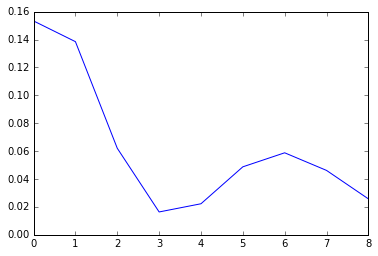

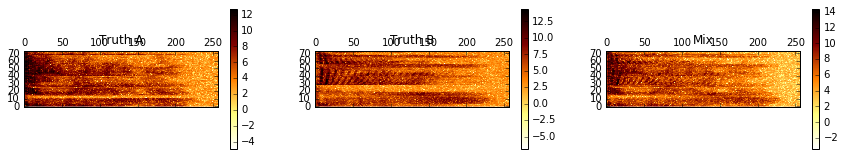

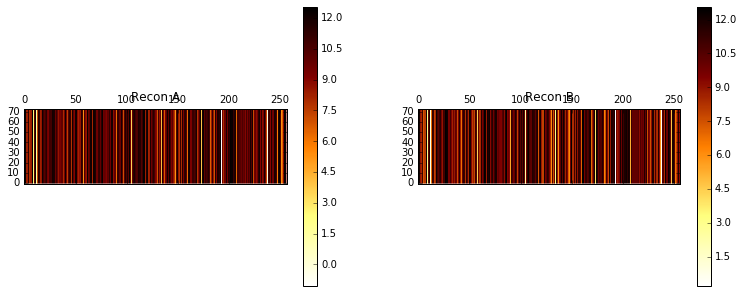

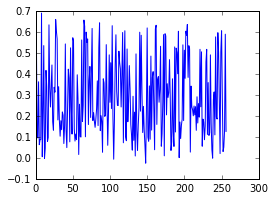

KeyboardInterrupt: 

In [8]:
with sess.as_default():
    for truth, mix in islice(batches, num_batches):
        data = {audio_features: mix,
                audio_truth: truth,
                learning_rate: 0.1}
        descent_step.run(feed_dict=data)        
        losses.append(loss.eval(feed_dict=data))
        if np.isnan(losses[-1]):
            raise ValueError("NaN loss")
        if len(losses) % 10 == 0:
            IPython.display.clear_output(wait=True)
            #plot_length = len(losses) * 0.9
            plot_start = int(len(losses) * 0.1)
            plt.plot(range(len(losses[plot_start:])), losses[plot_start:])
            # pull out an example and plot it
            out_a_img = ((out_a[0] * (af_max - af_min) + af_min)**2).eval(feed_dict=data)
            out_b_img = ((out_b[0] * (af_max - af_min) + af_min)**2).eval(feed_dict=data)
            plot_mix(np.log(np.absolute(truth[0][0].real)), 
                     np.log(np.absolute(truth[0][1].real)), 
                     np.log(np.absolute(mix[0].real)))
            plot_recons(np.log(np.absolute(out_a_img.real)), np.log(np.absolute(out_b_img.real)))
            # Mask
            mask_img = mask_weights.eval()
            plt.figure(figsize=(4,3))
            plt.plot(mask_img[0])
            
            # Audio reconstruction
            # Something wrong here
            truth_01 = np.log(np.abs(truth[0][0]))
            out_a_logabs = np.log(np.abs(out_a_img))
            #truth_01 = truth_01 / np.max(truth_01)
            recon_a_audio = istft(np.absolute(np.exp(out_a_logabs)) * np.exp(1j * np.angle(mix[0])), fs=1, 
                       recon_size=sig_length*stft_step, hop=stft_step, two_sided=False)
            truth_a_audio = istft(np.absolute(np.exp(truth_01)) * np.exp(1j * np.angle(mix[0])), fs=1, 
                       recon_size=sig_length*stft_step, hop=stft_step, two_sided=False)
            print('Truth A')
            display(Audio(truth_a_audio, rate=fs))
            print('Recon A')
            display(Audio(recon_a_audio, rate=fs))
            plt.show()

In [ ]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices() 
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()



In [ ]:
with sess.as_default():
    m = audio_features_norm.eval(data)
m

In [13]:
out_a_img

array([[   5842.02587891,  238612.25      ,    4021.76977539, ...,
           6523.93945312,  222106.203125  ,    6282.17724609],
       [   5842.02587891,  238612.25      ,    4021.76977539, ...,
           6523.93945312,  222106.203125  ,    6282.17724609],
       [   5842.02587891,  238612.25      ,    4021.76977539, ...,
           6523.93945312,  222106.203125  ,    6282.17724609],
       ..., 
       [   5842.02587891,  238612.25      ,    4021.76977539, ...,
           6523.93945312,  222106.203125  ,    6282.17724609],
       [   5842.02587891,  238612.25      ,    4021.76977539, ...,
           6523.93945312,  222106.203125  ,    6282.17724609],
       [   5842.02587891,  238612.25      ,    4021.76977539, ...,
           6523.93945312,  222106.203125  ,    6282.17724609]], dtype=float32)

In [14]:
truth_01

array([[  8.95618537,   9.37981726,  11.78417314, ...,   2.43159742,
          3.7053676 ,   4.05252694],
       [  7.74958832,   9.01194757,  11.8155502 , ...,   3.55679132,
          1.13036943,  -0.71260027],
       [  7.94526177,   9.21669697,  11.65880724, ...,   4.16311926,
          4.01236843,   3.93237203],
       ..., 
       [  8.22801796,   8.26770065,  10.7178262 , ...,   3.25540694,
          3.69399993,   3.53614981],
       [  7.05366895,   8.26476266,  10.26162225, ...,   3.32329925,
          3.37948136,   3.80053115],
       [  7.35500109,   7.81296675,   9.5207004 , ...,   3.51172401,
          2.08898188,   2.17036454]])